Raw data loaded successfully...

讀取完畢 檔案分割成功

開始訓練

Epoch: 000/150 cost: 40.182313283
Training accuracy: 0.070
Epoch: 001/150 cost: 36.353499942
Training accuracy: 0.100
Epoch: 002/150 cost: 29.858394411
Training accuracy: 0.100
Epoch: 003/150 cost: 25.646487130
Training accuracy: 0.240
Epoch: 004/150 cost: 22.237910165
Training accuracy: 0.190
Epoch: 005/150 cost: 20.965688282
Training accuracy: 0.150
Epoch: 006/150 cost: 16.886809773
Training accuracy: 0.340
Epoch: 007/150 cost: 14.118513213
Training accuracy: 0.300
Epoch: 008/150 cost: 14.126737383
Training accuracy: 0.340
Epoch: 009/150 cost: 12.396931860
Training accuracy: 0.350
Epoch: 010/150 cost: 9.892620934
Training accuracy: 0.440
Epoch: 011/150 cost: 9.569947031
Training accuracy: 0.530
Epoch: 012/150 cost: 8.647365411
Training accuracy: 0.490
Epoch: 013/150 cost: 7.979357190
Training accuracy: 0.450
Epoch: 014/150 cost: 6.250548522
Training accuracy: 0.500
Epoch: 015/150 cost: 6.298014164
Training accuracy: 0.630
Epoch: 016

Epoch: 143/150 cost: 0.808113482
Training accuracy: 0.860
Epoch: 144/150 cost: 0.797144615
Training accuracy: 0.940
Epoch: 145/150 cost: 0.664839748
Training accuracy: 0.860
Epoch: 146/150 cost: 0.657922924
Training accuracy: 0.850
Epoch: 147/150 cost: 0.576145172
Training accuracy: 0.810
Epoch: 148/150 cost: 0.383583690
Training accuracy: 0.930
Epoch: 149/150 cost: 0.386179251
Training accuracy: 0.960
訓練完成
開始測試...

Test accuracy: 0.233
Session closed!


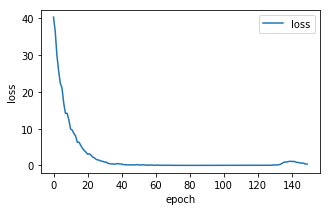

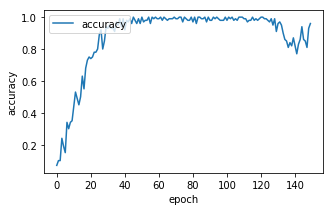

In [12]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing 
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

FILE_PATH = 'concrete.csv'                                # csv path
raw_data = pd.read_csv(FILE_PATH)						    

print("Raw data loaded successfully...\n")
#------------------------------------------------------------------------------
# 參數

Y_LABEL = 'strength'                                   		    # 結果label
KEYS = [i for i in raw_data.keys().tolist() if i != Y_LABEL]	# 用來運算預測的key
N_INSTANCES = raw_data.shape[0]                     			# Number of instances
N_INPUT = raw_data.shape[1] - 1                     			# Input size
TEST_SIZE = 0.1                                    			    # 測試數
TRAIN_SIZE = int(N_INSTANCES * (1 - TEST_SIZE))     			# 訓練大小
LEARNING_RATE = 0.001                              			    # 學習rate
TRAINING_EPOCHS = 150                               			# epochs
BATCH_SIZE = 100                                    			# Batch size
DISPLAY_STEP = 1                                    			# Display progress each x epochs
HIDDEN_SIZE = 450	                                   	    	# Number of hidden neurons
STDDEV = 0.1                                        			# Standard deviation (for weights random init)
RANDOM_STATE = 100 									            # Random state for train_test_split

#------------------------------------------------------------------------------
# Loading data

# Load 標準化 data
data = preprocessing.scale(raw_data[KEYS].get_values()) # 標準化 X data       
labels = [int(i) for i in raw_data[Y_LABEL].get_values()] # y data 			
N_CLASSES = max(labels) + 1                          # 類型數

# One hot encoding for labels
labels_ = np.zeros((N_INSTANCES, N_CLASSES))
labels_[np.arange(N_INSTANCES), labels] = 1

# Train-test split
data_train, data_test, labels_train, labels_test = train_test_split(data,
                                                                    labels_,
                                                                    test_size = TEST_SIZE,
                                                                    random_state = RANDOM_STATE)

print("讀取完畢 檔案分割成功\n")
#------------------------------------------------------------------------------
#神經網路架構

# Tf placeholders
X = tf.placeholder(tf.float32, [None, N_INPUT])
y = tf.placeholder(tf.float32, [None, N_CLASSES])
dropout_keep_prob = tf.placeholder(tf.float32)

# 自定義層次函數
def layer(output_dim, input_dim, inputs, activation = None):
    W = tf.Variable(tf.random_normal([input_dim, output_dim]))
    b = tf.Variable(tf.random_normal([1, output_dim]))
    XWb = tf.matmul(inputs, W) + b
    if activation is None:
        outputs = XWb
    else:
        outputs = activation(XWb)
    return outputs

# Build model
h1 = layer(output_dim = HIDDEN_SIZE, input_dim = N_INPUT, inputs = X, activation = tf.nn.tanh)
h2 = layer(output_dim = HIDDEN_SIZE, input_dim = HIDDEN_SIZE, inputs = h1, activation = tf.nn.tanh)
h3 = layer(output_dim = HIDDEN_SIZE, input_dim = HIDDEN_SIZE, inputs = h2, activation = tf.nn.tanh)
pred = layer(output_dim = N_CLASSES, input_dim = HIDDEN_SIZE, inputs = h3, activation = None)
#loss以及優化公式
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE).minimize(cost)

#計算正確率
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#初始化
init = tf.initialize_all_variables()

print("開始訓練\n")
#------------------------------------------------------------------------------
# Training

sess = tf.Session()
sess.run(init)
loss_list = []
epoch_list = []
accuracy_list = []

#訓練迴圈
for epoch in range(TRAINING_EPOCHS):
    avg_cost = 0.
    total_batch = int(data_train.shape[0] / BATCH_SIZE)
    #batches
    for i in range(total_batch):
        randidx = np.random.randint(int(TRAIN_SIZE), size = BATCH_SIZE)
        batch_xs = data_train[randidx, :]
        batch_ys = labels_train[randidx, :]
        #優化
        sess.run(optimizer, feed_dict={X: batch_xs, y: batch_ys, dropout_keep_prob: 0.9})
        #平均loss
        avg_cost += sess.run(cost, feed_dict={X: batch_xs, y: batch_ys, dropout_keep_prob:1.})/total_batch
    #log
    if epoch % DISPLAY_STEP == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, TRAINING_EPOCHS, avg_cost))
        train_acc = sess.run(accuracy, feed_dict={X: batch_xs, y: batch_ys, dropout_keep_prob:1.})
        print ("Training accuracy: %.3f" % (train_acc))
        epoch_list.append(epoch)
        loss_list.append(avg_cost)
        accuracy_list.append(train_acc)



print ("訓練完成")
print("開始測試...\n")
#------------------------------------------------------------------------------
# Testing

test_acc = sess.run(accuracy, feed_dict={X: data_test, y: labels_test, dropout_keep_prob:1.})
print ("Test accuracy: %.3f" % (test_acc))

sess.close()
print("Session closed!")

#顯示曲線圖
#%matplotlib inline
fig = plt.gcf()
fig.set_size_inches(5, 3)
plt.plot(epoch_list, loss_list, label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc = 'upper right')
plt.show()

fig = plt.gcf()
fig.set_size_inches(5, 3)
plt.plot(epoch_list, accuracy_list, label = 'accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc = 'upper left')
plt.show()
